In [1]:
import shap
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from optuna.samplers import TPESampler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

/opt/anaconda3/envs/IDS/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Загрузка модели

In [2]:
# Инициализируем модель CatBoostRegressor
model = CatBoostRegressor()

# Загружаем модель из файла "best_model.cbm"
model.load_model("best_model.cbm");

### Чтение файлов для прогноза

In [3]:
# Загружаем данные для предсказаний из файла "data_to_predict.xlsx"
data_to_predict = pd.read_excel("data_to_predict.xlsx")

# Удаляем столбец "link" из датафрейма
df = data_to_predict.drop("link", axis=1)

### Обработка пропущенных значений

In [4]:
# Обработка пропущенных значений
# Заполняем пропущенные значения средними значениями по каждому столбцу
df.fillna(df.mean(), inplace=True)

/var/folders/by/lz7sbv9d1h566t7sjlmxxpyc0000gn/T/ipykernel_55759/712577440.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.fillna(df.mean(), inplace=True)


### Матрица корреляции признаков

/var/folders/by/lz7sbv9d1h566t7sjlmxxpyc0000gn/T/ipykernel_55759/3797581801.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()
/opt/anaconda3/envs/IDS/lib/python3.9/site-packages/seaborn/matrix.py:256: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


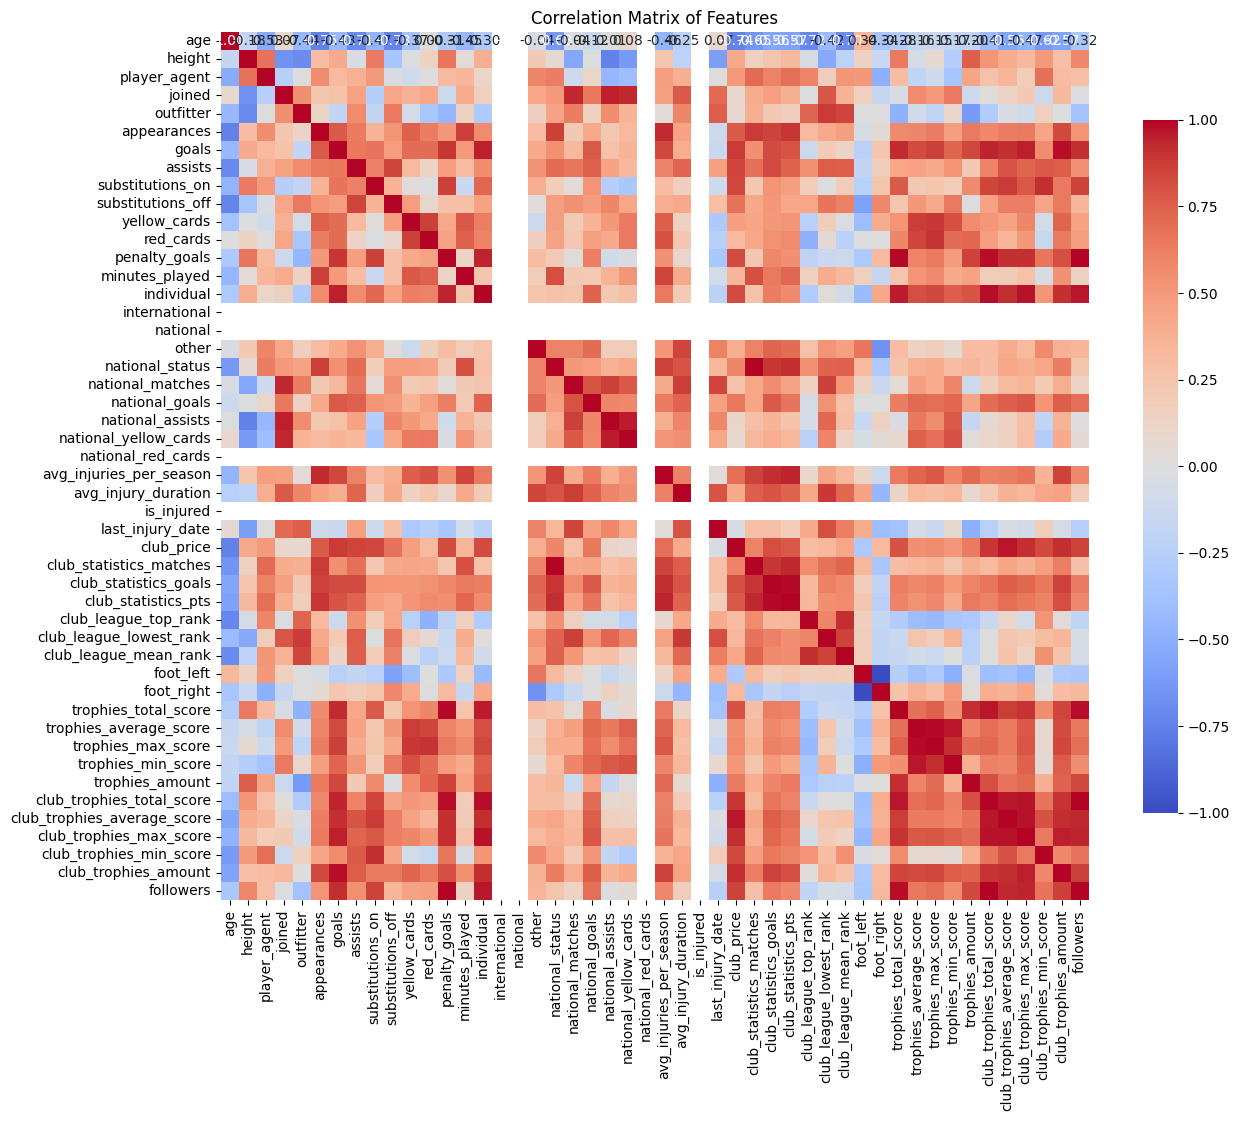

In [5]:
# Визуализация матрицы корреляций
plt.figure(figsize=(14, 12))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": 0.75})
plt.title("Correlation Matrix of Features")
plt.savefig("correlation_matrix.png")
plt.show()

### Анализ важности признаков

Text(0.5, 1.0, 'CatBoost features importance:')

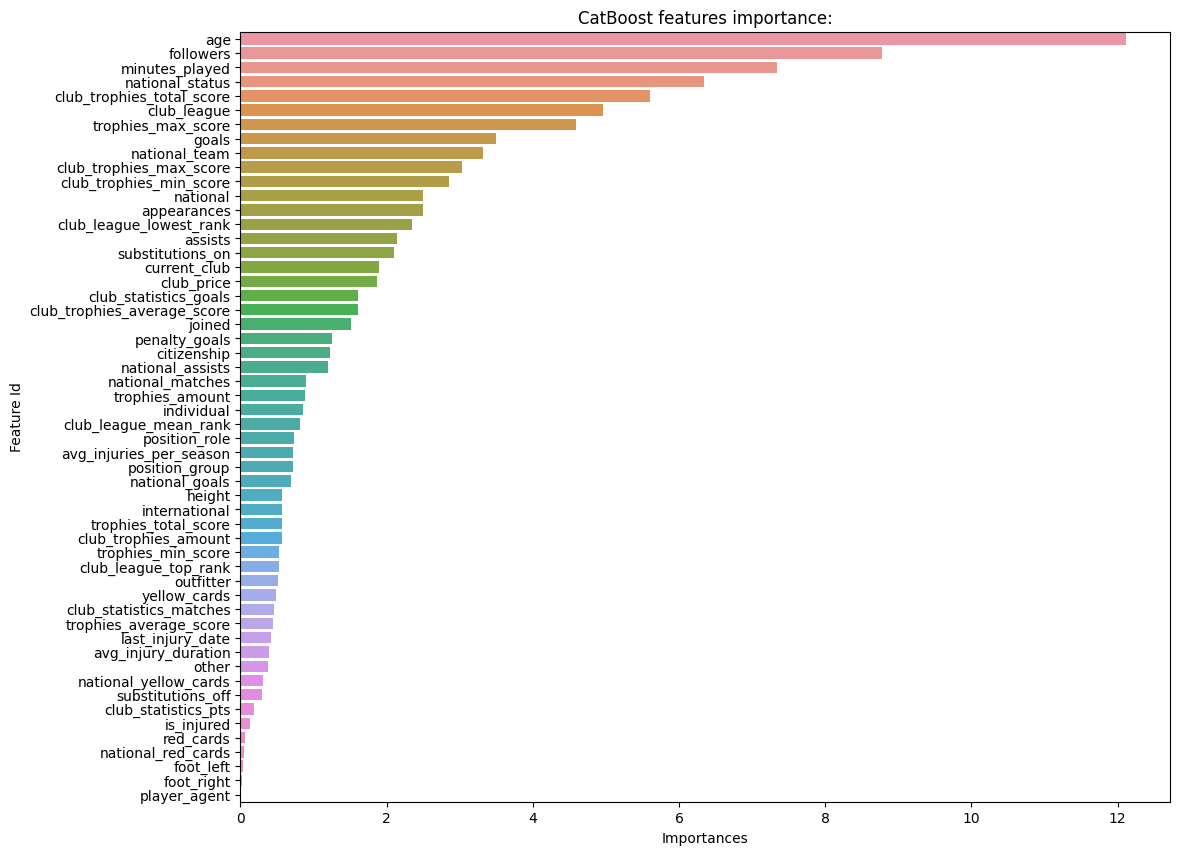

In [6]:
# Получаем информацию об относительной важности признаков в обученной модели
feature_importances = model.get_feature_importance(
    type="FeatureImportance", prettified=True
)

# Создаем график важности признаков
plt.figure(figsize=(12, 10))  # определяем размер графика
# Создаем горизонтальный график (barplot) с помощью seaborn (sns), где y - это признаки, а x - их важность
sns.barplot(x="Importances", y="Feature Id", data=feature_importances)
plt.title("CatBoost features importance:")  # добавляем название графика

### Анализ прогноза

In [7]:
index = int(input('Введите номер записи для прогноза:'))

Введите номер записи для прогноза: 1


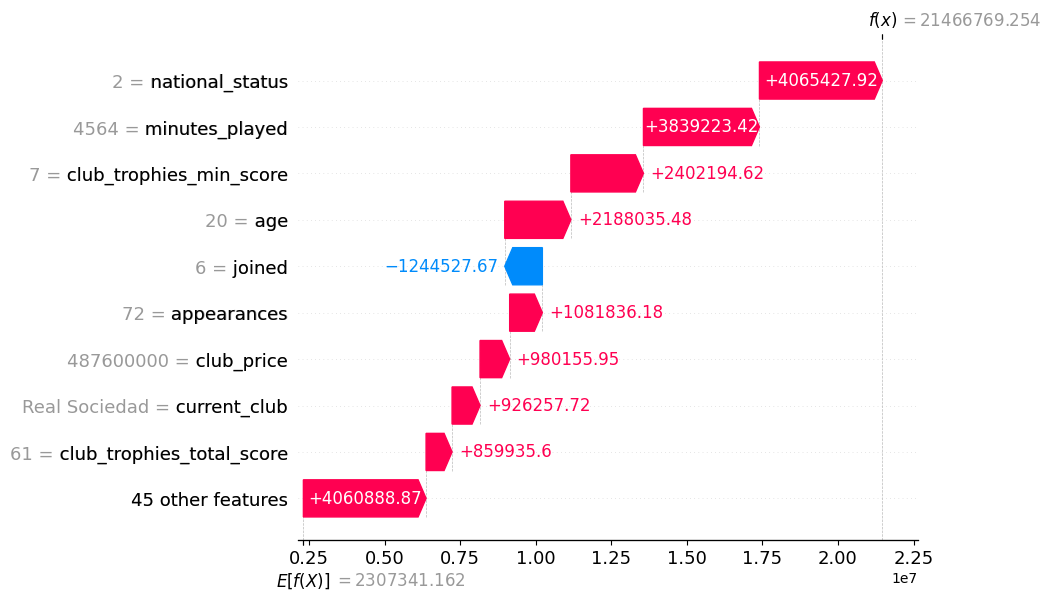

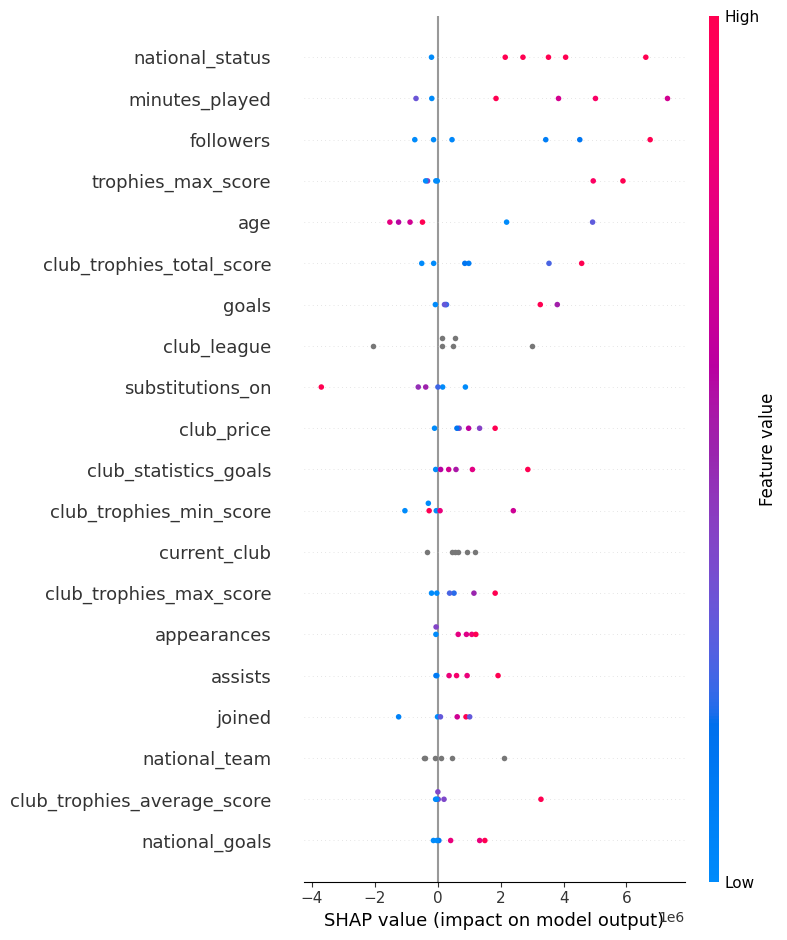

In [8]:
# Инициализируем JavaScript для корректной работы библиотеки SHAP
shap.initjs()

# Создаем объект explainer, который объясняет влияние признаков на предсказания модели
explainer = shap.Explainer(model)

# Вычисляем SHAP значения (вклад каждого признака в предсказание) для нашего набора данных
shap_values = explainer(df)

# Создаем waterfall plot, который показывает влияние каждого признака на предсказание для конкретного наблюдения
shap.plots.waterfall(shap_values[index-1])

# Создаем сводную SHAP диаграмму (summary plot), которая показывает важность признаков и их воздействие
shap.summary_plot(shap_values, df)

### Сохранение прогнозов

In [9]:
# Делаем предсказания с помощью нашей модели, округляем результаты и добавляем их в исходный датафрейм data_to_predict
data_to_predict["predicted_price"] = np.round(model.predict(df))

In [10]:
# Сохраняем итоговый датафрейм с предсказаниями в новый файл Excel
data_to_predict.to_excel("data_with_predictions.xlsx", index=False)